In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#make the original data
series = np.sin((0.1*np.arange(400))**2)

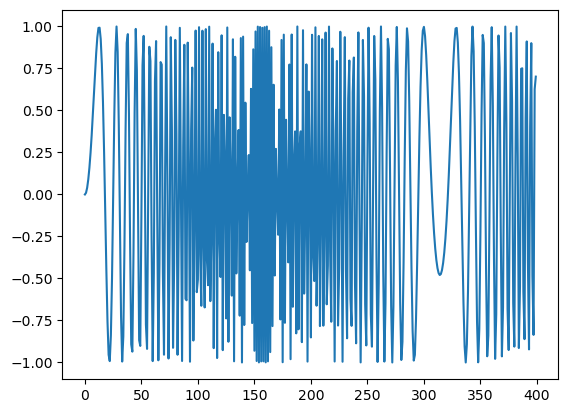

In [10]:
#plot it 
plt.plot (series)
plt.show()

In [6]:
series.shape

(400,)

In [12]:
#build the dataset
#lets see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)
X = np.array(X).reshape(-1, T) #make it N x T
Y = np.array(Y).reshape(-1, 1)
N = len(X)
print("X.shape", X.shape, "Y.shape",Y.shape)

X.shape (390, 10) Y.shape (390, 1)


In [15]:
series[t:t+T]

array([-0.86121682,  0.45213334,  0.91096696, -0.39051633, -0.92214359,
        0.40156874,  0.90077416, -0.4840401 , -0.83575817,  0.62669331])

In [26]:
series[t+T]

0.7014823862144136

In [27]:
# try autoregressive model
model = nn.Linear(T,1)

In [28]:
#Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [37]:
#Make inputs and targets
X_train = torch.from_numpy(X[:-N//2].astype(np.float32))
y_train = torch.from_numpy(Y[:-N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [36]:
type(X_train), type(X_test)

(torch.Tensor, torch.Tensor)

In [41]:
len(X)

390

In [45]:
#Training
def full_gd(model,
            criterion,
            optimizer,
            X_train,
            y_train,
            X_test,
            y_test,
            epochs=200):
    #Stuff to store
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):
        #zero the parameter gradients
        optimizer.zero_grad()
        #forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        #Backward and optimize
        loss.backward()
        optimizer.step()

        #save losses
        train_losses[it] = loss.item()

        #test loss
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses[it] = test_loss.item()

        if (it + 1) % 5 == 0:
            print(f'Epoch {it + 1}/ {epochs}, Train Loss: {loss.item():.4f}, Test Loss: {test_loss:.4f}')
    return train_losses, test_losses

In [46]:
train_losses, test_losses = full_gd(model, criterion, optimizer, X_train, y_train, X_test, y_test)

Epoch 5/ 200, Train Loss: 0.5367, Test Loss: 0.6158
Epoch 10/ 200, Train Loss: 0.5084, Test Loss: 0.6015
Epoch 15/ 200, Train Loss: 0.4919, Test Loss: 0.6077
Epoch 20/ 200, Train Loss: 0.4965, Test Loss: 0.5993
Epoch 25/ 200, Train Loss: 0.4860, Test Loss: 0.5962
Epoch 30/ 200, Train Loss: 0.4868, Test Loss: 0.5917
Epoch 35/ 200, Train Loss: 0.4857, Test Loss: 0.5915
Epoch 40/ 200, Train Loss: 0.4843, Test Loss: 0.5910
Epoch 45/ 200, Train Loss: 0.4838, Test Loss: 0.5890
Epoch 50/ 200, Train Loss: 0.4839, Test Loss: 0.5926
Epoch 55/ 200, Train Loss: 0.4837, Test Loss: 0.5884
Epoch 60/ 200, Train Loss: 0.4835, Test Loss: 0.5901
Epoch 65/ 200, Train Loss: 0.4834, Test Loss: 0.5893
Epoch 70/ 200, Train Loss: 0.4834, Test Loss: 0.5909
Epoch 75/ 200, Train Loss: 0.4834, Test Loss: 0.5887
Epoch 80/ 200, Train Loss: 0.4833, Test Loss: 0.5900
Epoch 85/ 200, Train Loss: 0.4833, Test Loss: 0.5898
Epoch 90/ 200, Train Loss: 0.4833, Test Loss: 0.5896
Epoch 95/ 200, Train Loss: 0.4833, Test Loss: 0

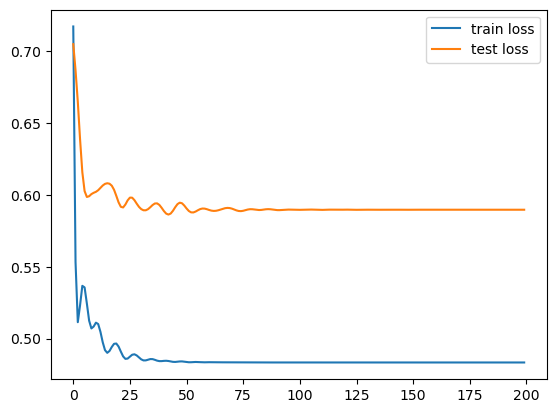

In [47]:
#plot the train loss and test loss per iteration
plt.plot(train_losses, label = 'train loss')
plt.plot(test_losses, label = 'test loss')
plt.legend()
plt.show()

In [48]:
#One step forecast using true targets
#Note: even the one-step forecast fails badly
validation_target = Y[-N//2:]
with torch.no_grad():
    validation_predictions = model(X_test).numpy()
#validation_predictions = []
# #index of first validation input
# i = 0
#while len(validation_predictions) < len(validation_target):
#input_ = X_test[i].reshap(1,-1)
#p = model(input_)[,].item() # 1x1 array -> scalar
# i += 1

#update the prediction.append(p)

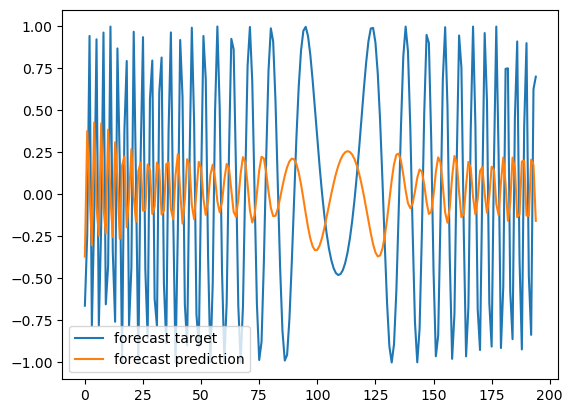

In [56]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

In [60]:
#Multi-step forecast
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
#last_x = torch.numpy(X[-N//2]) # 1-D array of length T
last_x = torch.from_numpy(X[-N//2].astype(np.float32))

while len(validation_predictions) < len(validation_target):
    input_ = last_x.reshape(1,-1)
    p = model(input_)
    # [,0] # 1x1 array - > scalar

    #update the predictions list
    validation_predictions.append(p[0,0].item())

    #make the new input
    last_x = torch.cat((last_x[1:],p[0]))

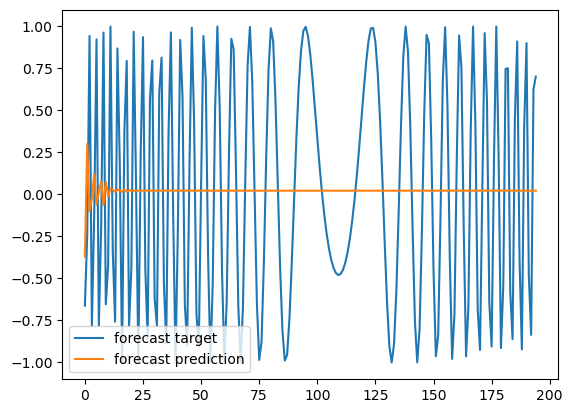

In [61]:
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()